In [2]:
# A. Marinovich - Springboard Capstone Project - TrackML Challenge
# R and Python jupyter notebook with markdown at Azure Notebooks: https://notebooks.azure.com/adriatic/libraries/trackml  
# Version control at GitHub repository: github.com/adriatic13/trackml

The capstone project comprises the Kaggle TrackML Particle Tracking Challenge (https://www.kaggle.com/c/trackml-particle-identification/) and related submission dataset, code and jupyter notebook. This challenges participants to "build an algorithm that quickly reconstructs particle tracks from 3D points left in the silicon detectors" in the CERN Large Hadron Collider, specifically to "group the recorded measurements or hits for each event into tracks, sets of hits that belong to the same initial particle. A solution must uniquely associate each hit to one track." The client would be the high-energy physics research community, which has demand for new algorithms to process increasing data loads from next-generation particle experiments. The training and test datasets are provided by CERN via Kaggle, and consist of 3D simulated measurements of particles resulting from proton collisions, such that the "training dataset contains the recorded hits, their ground truth counterpart and their association to particles, and the initial parameters of those particles. The test dataset contains only the recorded hits." 

The overall approach is to use machine learning algorithms to classify the detector hits into groups corresponding to the presumed particle tracks giving rise to those hits. The immediate deliverable will be the submission dataset to the Kaggle challenge, consisting of a csv file with three columns corresponding to events, hits and tracks. This will be verified against the ground truths held by the challenge administrators, and ranked accordingly. Subsequent deliverables following the challenge deadline will be the code itself embedded within a jupyter notebook. The challenge entry deadline is August 6, 2018, and the final submission deadline is August 13, 2018.

In [41]:
# Run in Python
# <https://github.com/LAL/trackml-library.git>
# in terminal: git clone https://github.com/LAL/trackml-library.git

# this is dataset.py

"""TrackML dataset loading"""

__authors__ = ['Moritz Kiehn', 'Sabrina Amrouche', 'Nimar Arora']

import glob
import os
import os.path as op
import re
import zipfile

import pandas

CELLS_DTYPES = dict([
    ('hit_id', 'i4'),
    ('ch0', 'i4'),
    ('ch1', 'i4'),
    ('value', 'f4'),
])
HITS_DTYPES = dict([
    ('hit_id', 'i4'),
    ('x', 'f4'),
    ('y', 'f4'),
    ('z','f4'),
    ('volume_id', 'i4'),
    ('layer_id', 'i4'),
    ('module_id', 'i4'),
])
PARTICLES_DTYPES = dict([
    ('particle_id', 'i8'),
    ('vx', 'f4'),
    ('vy', 'f4'),
    ('vz', 'f4'),
    ('px', 'f4'),
    ('py', 'f4'),
    ('pz', 'f4'),
    ('q', 'i4'),
    ('nhits', 'i4'),
])
TRUTH_DTYPES = dict([
    ('hit_id', 'i4'),
    ('particle_id', 'i8'),
    ('tx', 'f4'),
    ('ty', 'f4'),
    ('tz', 'f4'),
    ('tpx', 'f4'),
    ('tpy', 'f4'),
    ('tpz', 'f4'),
    ('weight', 'f4'),
])
DTYPES = {
    'cells': CELLS_DTYPES,
    'hits': HITS_DTYPES,
    'particles': PARTICLES_DTYPES,
    'truth': TRUTH_DTYPES,
}
DEFAULT_PARTS = ['hits', 'cells', 'particles', 'truth']

def _load_event_data(prefix, name):
    """Load per-event data for one single type, e.g. hits, or particles.
    """
    expr = '{!s}-{}.csv*'.format(prefix, name)
    files = glob.glob(expr)
    dtype = DTYPES[name]
    if len(files) == 1:
        return pandas.read_csv(files[0], header=0, index_col=False, dtype=dtype)
    elif len(files) == 0:
        raise Exception('No file matches \'{}\''.format(expr))
    else:
        raise Exception('More than one file matches \'{}\''.format(expr))

def load_event_hits(prefix):
    """Load the hits information for a single event with the given prefix.
    """
    return _load_event_data(prefix, 'hits')

def load_event_cells(prefix):
    """Load the hit cells information for a single event with the given prefix.
    """
    return _load_event_data(prefix, 'cells')

def load_event_particles(prefix):
    """Load the particles information for a single event with the given prefix.
    """
    return _load_event_data(prefix, 'particles')

def load_event_truth(prefix):
    """Load only the truth information for a single event with the given prefix.
    """
    return _load_event_data(prefix, 'truth')

def load_event(prefix, parts=DEFAULT_PARTS):
    """Load data for a single event with the given prefix.

    Parameters
    ----------
    prefix : str or pathlib.Path
        The common prefix name for the event files, i.e. without `-hits.csv`).
    parts : List[{'hits', 'cells', 'particles', 'truth'}], optional
        Which parts of the event files to load.

    Returns
    -------
    tuple
        Contains a `pandas.DataFrame` for each element of `parts`. Each
        element has field names identical to the CSV column names with
        appropriate types.
    """
    return tuple(_load_event_data(prefix, name) for name in parts)

def load_dataset(path, skip=None, nevents=None, parts=DEFAULT_PARTS):
    """Provide an iterator over (all) events in a dataset.

    Parameters
    ----------
    path : str or pathlib.Path
        Path to a directory or a zip file containing event files.
    skip : int, optional
        Skip the first `skip` events.
    nevents : int, optional
        Only load a maximum of `nevents` events.
    parts : List[{'hits', 'cells', 'particles', 'truth'}], optional
        Which parts of each event files to load.

    Yields
    ------
    event_id : int
        The event identifier.
    *data
        Event data element as specified in `parts`.
    """
    # extract a sorted list of event file prefixes.
    def list_prefixes(files):
        # Note: the file names may optionally have a directory prefix if they
        # are derived from a zipfile, for example. Hence the regular expression
        # can't be anchored at the beginning of the file name.
        regex = re.compile('.*event\d{9}-[a-zA-Z]+.csv$')
        files = filter(regex.match, files)
        prefixes = set(_.split('-', 1)[0] for _ in files)
        prefixes = sorted(prefixes)
        if skip is not None:
            prefixes = prefixes[skip:]
        if nevents is not None:
            prefixes = prefixes[:nevents]
        return prefixes

    # TODO use yield from when we increase the python requirement
    if op.isdir(path):
        for x in _iter_dataset_dir(path, list_prefixes(os.listdir(path)), parts):
            yield x
    else:
        with zipfile.ZipFile(path, mode='r') as z:
            for x in _iter_dataset_zip(z, list_prefixes(z.namelist()), parts):
                yield x

def _extract_event_id(prefix):
    """Extract event_id from prefix, e.g. event_id=1 from `event000000001`
    or from `train_1/event000000001`
    """
    regex = r".*event(\d+)"
    groups = re.findall(regex, prefix)
    return int(groups[0])

def _iter_dataset_dir(directory, prefixes, parts):
    """Iterate over selected events files inside a directory.
    """
    for p in prefixes:
        yield (_extract_event_id(p),) + load_event(op.join(directory, p), parts)

def _iter_dataset_zip(zipfile, prefixes, parts):
    """Iterate over selected event files inside a zip archive.
    """
    for p in prefixes:
        files = [zipfile.open('{}-{}.csv'.format(p, _), mode='r') for _ in parts]
        dtypes = [DTYPES[_] for _ in parts]
        data = tuple(pandas.read_csv(f, header=0, index_col=False, dtype=d)
                                     for f, d in zip(files, dtypes))
        yield (_extract_event_id(p),) + data

In [42]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [43]:
# Run in Python
# <https://github.com/LAL/trackml-library.git>
# in terminal: git clone https://github.com/LAL/trackml-library.git

# this is score.py
#    It was edited to remove validate='one_to_one' argument from pandas.merge line
#      see:
#         help(pandas.merge)

"""TrackML scoring metric"""

__authors__ = ['Sabrina Amrouche', 'David Rousseau', 'Moritz Kiehn',
               'Ilija Vukotic']

import numpy
import pandas

def _analyze_tracks(truth, submission):
    """Compute the majority particle, hit counts, and weight for each track.

    Parameters
    ----------
    truth : pandas.DataFrame
        Truth information. Must have hit_id, particle_id, and weight columns.
    submission : pandas.DataFrame
        Proposed hit/track association. Must have hit_id and track_id columns.

    Returns
    -------
    pandas.DataFrame
        Contains track_id, nhits, major_particle_id, major_particle_nhits,
        major_nhits, and major_weight columns.
    """
    # true number of hits for each particle_id
    particles_nhits = truth['particle_id'].value_counts(sort=False)
    total_weight = truth['weight'].sum()
    # combined event with minimal reconstructed and truth information
    event = pandas.merge(truth[['hit_id', 'particle_id', 'weight']],
                         submission[['hit_id', 'track_id']],
                         on=['hit_id'], how='left')
    event.drop('hit_id', axis=1, inplace=True)
    event.sort_values(by=['track_id', 'particle_id'], inplace=True)

    # ASSUMPTIONs: 0 <= track_id, 0 <= particle_id

    tracks = []
    # running sum for the reconstructed track we are currently in
    rec_track_id = -1
    rec_nhits = 0
    # running sum for the particle we are currently in (in this track_id)
    cur_particle_id = -1
    cur_nhits = 0
    cur_weight = 0
    # majority particle with most hits up to now (in this track_id)
    maj_particle_id = -1
    maj_nhits = 0
    maj_weight = 0

    for hit in event.itertuples(index=False):
        # we reached the next track so we need to finish the current one
        if (rec_track_id != -1) and (rec_track_id != hit.track_id):
            # could be that the current particle is the majority one
            if maj_nhits < cur_nhits:
                maj_particle_id = cur_particle_id
                maj_nhits = cur_nhits
                maj_weight = cur_weight
            # store values for this track
            tracks.append((rec_track_id, rec_nhits, maj_particle_id,
                particles_nhits[maj_particle_id], maj_nhits,
                maj_weight / total_weight))

        # setup running values for next track (or first)
        if rec_track_id != hit.track_id:
            rec_track_id = hit.track_id
            rec_nhits = 1
            cur_particle_id = hit.particle_id
            cur_nhits = 1
            cur_weight = hit.weight
            maj_particle_id = -1
            maj_nhits = 0
            maj_weights = 0
            continue

        # hit is part of the current reconstructed track
        rec_nhits += 1

        # reached new particle within the same reconstructed track
        if cur_particle_id != hit.particle_id:
            # check if last particle has more hits than the majority one
            # if yes, set the last particle as the new majority particle
            if maj_nhits < cur_nhits:
                maj_particle_id = cur_particle_id
                maj_nhits = cur_nhits
                maj_weight = cur_weight
            # reset runnig values for current particle
            cur_particle_id = hit.particle_id
            cur_nhits = 1
            cur_weight = hit.weight
        # hit belongs to the same particle within the same reconstructed track
        else:
            cur_nhits += 1
            cur_weight += hit.weight

    # last track is not handled inside the loop
    if maj_nhits < cur_nhits:
        maj_particle_id = cur_particle_id
        maj_nhits = cur_nhits
        maj_weight = cur_weight
    # store values for the last track
    tracks.append((rec_track_id, rec_nhits, maj_particle_id,
        particles_nhits[maj_particle_id], maj_nhits, maj_weight / total_weight))

    cols = ['track_id', 'nhits',
            'major_particle_id', 'major_particle_nhits',
            'major_nhits', 'major_weight']
    return pandas.DataFrame.from_records(tracks, columns=cols)

def score_event(truth, submission):
    """Compute the TrackML event score for a single event.

    Parameters
    ----------
    truth : pandas.DataFrame
        Truth information. Must have hit_id, particle_id, and weight columns.
    submission : pandas.DataFrame
        Proposed hit/track association. Must have hit_id and track_id columns.
    """
    tracks = _analyze_tracks(truth, submission)
    purity_rec = numpy.true_divide(tracks['major_nhits'], tracks['nhits'])
    purity_maj = numpy.true_divide(tracks['major_nhits'], tracks['major_particle_nhits'])
    good_track = (0.5 < purity_rec) & (0.5 < purity_maj)
    return tracks['major_weight'][good_track].sum()


In [45]:
path_to_train = ""

In [46]:
event_prefix = "event000001000"

In [47]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [48]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [106]:
# Run in Python
#
# EDITED from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#   TO USE DOUBLE transform

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
            
    def _preprocess(self, hits):
        
        x1 = hits.x.values
        y1 = hits.y.values
        z1 = hits.z.values

        r_xyz = np.sqrt(x1**2 + y1**2 + z1**2)
        z_rxyz = z1/r_xyz

        r1 = np.sqrt(x1**2 + y1**2)
        phi1 = np.arctan2(y1, x1)

        #FIRST: CURVE-STRAIGHTENING CONFORMAL TRANSFORM:
        x2 = x1/(r1**2)
        y2 = y1/(r1**2)
        r2 = np.sqrt(x2**2 + y2**2)
        phi2 = np.arctan2(y2, x2)

        #SECOND: CORE-OUT BELOW R-TAU:
        r_tau = 0.1
        r3 = np.where(r2<r_tau, r2 + 2*(r_tau - r2), r2)
        phi3 = np.arctan2(y2, x2)
        x3 = r3*(np.cos(phi3))
        y3 = r3*(np.sin(phi3))
        
        hits['X'] = x3
        hits['Y'] = y3
        hits['Z'] = z1/r1
        
        ss = StandardScaler()
        X = ss.fit_transform(hits[['X', 'Y', 'Z']].values)
        
        return X
        
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [107]:
# Run in Python
# epsilon and r_tau focusing:
#     eps=0.0021 -> .1514 for sphere
#     eps=0.0075 -> .2035 for cylinder
#     eps=0.0045 -> .1319 for sphere hyperspace phi
#     eps=0.0021 -> .1471 for sphere hyperspace 1/phi
#     eps=0.001, r_tau=0.1 -> .00336 for double transform

model = Clusterer(eps=0.01)
labels = model.predict(hits)
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)
print("Your score: ", score)

Your score:  0.0033615885295148473


In [37]:
# Run in Python
# for DBSCAN
#
#     Edited to remove ref to cells files
#
#     Edited for manual pipelining of test events, 50 at a time. 
#        Need to load sets manually into library.
#

"""
Create a submission

Recognize tracks in all (or subset of) events of the test dataset and create a submission file.

"""

path_to_test = "test/"
test_dataset_submissions = []

create_submission = True # True for submission 

if create_submission:
    for event_id, hits in load_dataset(path_to_test, parts=['hits'], skip=0, nevents=50):

        # Track pattern recognition
        model = Clusterer(eps=0.008)
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submussion = pd.concat(test_dataset_submissions, axis=0)
    submussion.to_csv('submission_75_124.csv', index=False)

Event ID:  75
Event ID:  76
Event ID:  77
Event ID:  78
Event ID:  79
Event ID:  80
Event ID:  81
Event ID:  82
Event ID:  83
Event ID:  84
Event ID:  85
Event ID:  86
Event ID:  87
Event ID:  88
Event ID:  89
Event ID:  90
Event ID:  91
Event ID:  92
Event ID:  93
Event ID:  94
Event ID:  95
Event ID:  96
Event ID:  97
Event ID:  98
Event ID:  99
Event ID:  100
Event ID:  101
Event ID:  102
Event ID:  103
Event ID:  104
Event ID:  105
Event ID:  106
Event ID:  107
Event ID:  108
Event ID:  109
Event ID:  110
Event ID:  111
Event ID:  112
Event ID:  113
Event ID:  114
Event ID:  115
Event ID:  116
Event ID:  117
Event ID:  118
Event ID:  119
Event ID:  120
Event ID:  121
Event ID:  122
Event ID:  123
Event ID:  124


In [38]:
# Run in Python
# for DBSCAN
# Combining portions of submission file

submit_00_24=pd.read_csv('submission_00_24.csv') 
submit_25_74=pd.read_csv('submission_25_74.csv')
submit_75_124=pd.read_csv('submission_75_124.csv')

submit_0_124_db=pd.concat([submit_00_24, submit_25_74, submit_75_124],axis=0)

In [40]:
# Run in Python
# must be 13741466 rows in length for valid submission, and have header row
submit_0_124_db.shape
#submit_0_124_db.head()

(13741466, 3)

In [41]:
# Run in Python
# Create final submission file
submit_0_124_db.to_csv('submission_0_124_db.csv', index=False)

In [43]:
# Run in Python
# Create final submission file, compressed
submit_0_124_db.to_csv('adriatic_submission180607a.csv.gz', index=False, compression='gzip')

In [117]:
# Run in Python
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
r1000tru_p = pd.read_csv('event000001000-truth.csv')
r1000tru_p_wt = r1000tru_p[r1000tru_p['weight']!= 0]
r1000tru_p_sort = r1000tru_p_wt.sort_values('particle_id',axis=0,ascending=False)
r1000tru_p_sort = r1000tru_p_sort.reset_index(drop=True)

r1000tru_p_sort['pmag'] = np.sqrt(r1000tru_p_sort['tpx']**2 + r1000tru_p_sort['tpy']**2 + r1000tru_p_sort['tpz']**2)

#
#        DOUBLE TRANSFORM:
#
r1000tru_p_sort['x1'] = r1000tru_p_sort['tx']
r1000tru_p_sort['y1'] = r1000tru_p_sort['ty']
r1000tru_p_sort['z1'] = r1000tru_p_sort['tz']
r1000tru_p_sort['r1'] = np.sqrt(r1000tru_p_sort['x1']**2 + r1000tru_p_sort['y1']**2)
r1000tru_p_sort['r1z'] = np.sqrt(r1000tru_p_sort['x1']**2 + r1000tru_p_sort['y1']**2 + r1000tru_p_sort['z1']**2)
r1000tru_p_sort['phi1'] = np.arctan2(r1000tru_p_sort['y1'], r1000tru_p_sort['x1'])

#FIRST: CURVE-STRAIGHTENING CONFORMAL TRANSFORM:
r1000tru_p_sort['x2'] = r1000tru_p_sort['x1']/(r1000tru_p_sort['r1']**2)
r1000tru_p_sort['y2'] = r1000tru_p_sort['y1']/(r1000tru_p_sort['r1']**2)
r1000tru_p_sort['r2'] = np.sqrt(r1000tru_p_sort['x2']**2 + r1000tru_p_sort['y2']**2)
r1000tru_p_sort['phi2'] = np.arctan2(r1000tru_p_sort['y2'], r1000tru_p_sort['x2'])

#SECOND: CORE-OUT BELOW R-TAU:
r_tau = 0.1
r1000tru_p_sort['r3'] = np.where(r1000tru_p_sort['r2']<r_tau, 
                                 r1000tru_p_sort['r2'] + 2*(r_tau - r1000tru_p_sort['r2']),
                                 r1000tru_p_sort['r2'])

r1000tru_p_sort['phi3'] = np.arctan2(r1000tru_p_sort['y2'], r1000tru_p_sort['x2'])
r1000tru_p_sort['x3'] = r1000tru_p_sort['r3']*(np.cos(r1000tru_p_sort['phi3']))
r1000tru_p_sort['y3'] = r1000tru_p_sort['r3']*(np.sin(r1000tru_p_sort['phi3']))

#THIRD: CURVE-STRAIGHTENING TRANSFORM AGAIN:
#r1000tru_p_sort['x4'] = r1000tru_p_sort['x3']/(r1000tru_p_sort['r3']**2)
#r1000tru_p_sort['y4'] = r1000tru_p_sort['y3']/(r1000tru_p_sort['r3']**2)


#r1000tru_p_sort['delta3'] = np.arctan2(r1000tru_p_sort['y2'], r1000tru_p_sort['x2'])
#r1000tru_p_sort['delta3'] = np.where(r1000tru_p_sort['r2']<r_tau, 
#                                     r1000tru_p_sort['delta2']+(np.pi/4), 
#                                     r1000tru_p_sort['delta2'])
#r1000tru_p_sort['x3'] = r1000tru_p_sort['r3']*(np.cos(r1000tru_p_sort['delta3']))
#r1000tru_p_sort['y3'] = r1000tru_p_sort['r3']*(np.sin(r1000tru_p_sort['delta3']))


r1000tru_p_sort.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,pmag,x1,y1,z1,r1,r1z,phi1,x2,y2,r2,phi2,r3,phi3,x3,y3
0,72147,968306149319245824,240.654,103.8700,-595.695,0.533424,0.140989,-1.22240,0.000006,1.341149,240.654,103.8700,-595.695,262.113190,650.811691,0.407461,0.003503,0.001512,0.003815,0.407461,0.196185,0.407461,0.180123,0.077744
1,40414,968306149319245824,153.521,76.1241,-394.131,0.520745,0.195586,-1.22491,0.000009,1.345301,153.521,76.1241,-394.131,171.358035,429.770661,0.460326,0.005228,0.002592,0.005836,0.460326,0.194164,0.460326,0.173953,0.086256
2,78836,968306149319245824,337.507,124.1060,-815.241,0.539112,0.084138,-1.22426,0.000005,1.340348,337.507,124.1060,-815.241,359.601549,891.028149,0.352368,0.002610,0.000960,0.002781,0.352368,0.197219,0.352368,0.185102,0.068064
3,34428,968306149319245824,102.781,55.3116,-273.278,0.509048,0.227839,-1.22477,0.000010,1.345772,102.781,55.3116,-273.278,116.718923,297.160180,0.493700,0.007544,0.004060,0.008568,0.493700,0.191432,0.493700,0.168573,0.090717
4,34426,968306149319245824,101.102,54.5576,-269.237,0.508399,0.228993,-1.22487,0.000013,1.345813,101.102,54.5576,-269.237,114.883185,292.722921,0.494846,0.007660,0.004134,0.008704,0.494846,0.191296,0.494846,0.168348,0.090846


In [94]:
# Run in Python

# r1000tru_p_sort.loc[1:2,'tx']
# r1000tru_p_sort[['tx']]
r1000tru_p_sort.shape



(101172, 23)

<IPython.core.display.Javascript object>


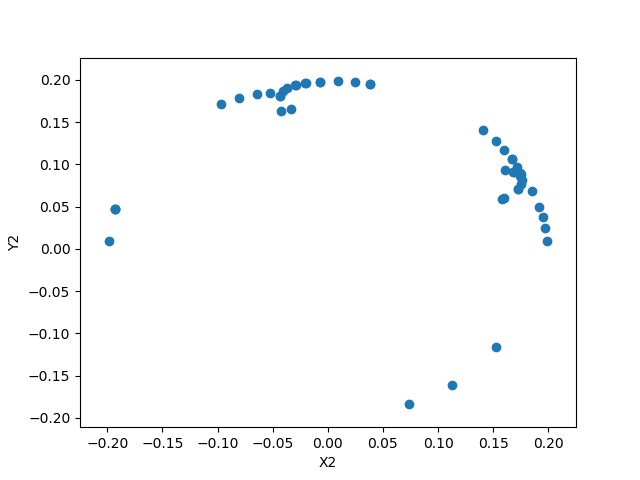

Text(0,0.5,'Y2')

In [113]:
# Run in Python

%matplotlib notebook
import matplotlib.pyplot as plt

plt.scatter(r1000tru_p_sort.loc[1:50,'x3'], r1000tru_p_sort.loc[1:50,'y3'])
plt.xlabel('X2')
plt.ylabel('Y2')

<IPython.core.display.Javascript object>


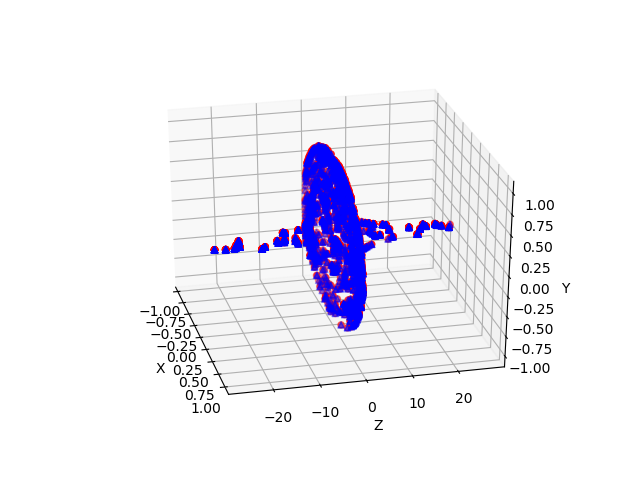

In [118]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:2000,'x1']/r1000tru_p_sort.loc[1:2000,'r1z']
    ys = r1000tru_p_sort.loc[1:2000,'z1']/r1000tru_p_sort.loc[1:2000,'r1']
    zs = r1000tru_p_sort.loc[1:2000,'y1']/r1000tru_p_sort.loc[1:2000,'r1z']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

In [2]:
r1000hit_p = pd.read_csv('event000001000-hits.csv')
r1000hit_p.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.4099,-7.163700,-1502.5,7,2,1
1,2,-55.3361,0.635342,-1502.5,7,2,1
2,3,-83.8305,-1.143010,-1502.5,7,2,1
3,4,-96.1091,-8.241030,-1502.5,7,2,1
4,5,-62.6736,-9.371200,-1502.5,7,2,1


<IPython.core.display.Javascript object>


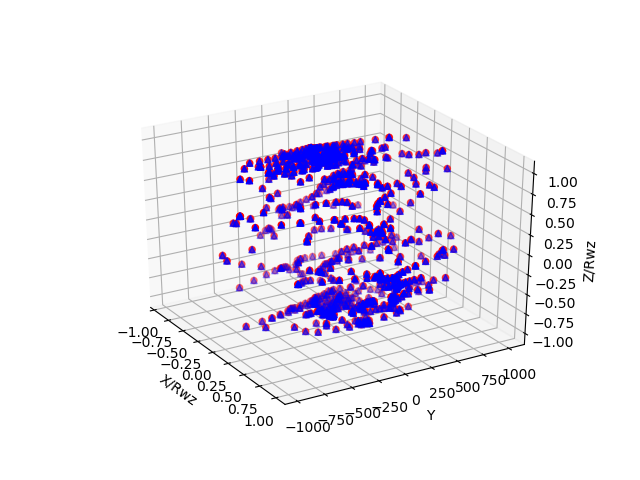

In [103]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:1000,'x_rwz']
    ys = r1000tru_p_sort.loc[1:1000,'ty']
    zs = r1000tru_p_sort.loc[1:1000,'z_rwz']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X/Rwz')
ax.set_ylabel('Y')
ax.set_zlabel('Z/Rwz')

plt.show()

<IPython.core.display.Javascript object>


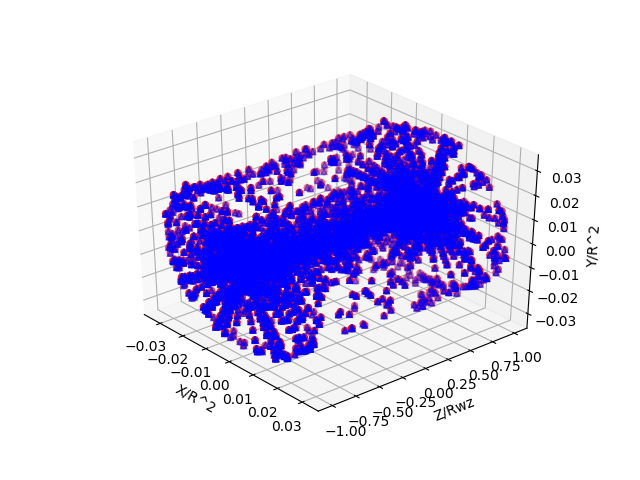

In [27]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:9000,'x_r2']
    ys = r1000tru_p_sort.loc[1:9000,'z_rwz']
    zs = r1000tru_p_sort.loc[1:9000,'y_r2']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X/R^2')
ax.set_ylabel('Z/Rwz')
ax.set_zlabel('Y/R^2')

plt.show()

<IPython.core.display.Javascript object>


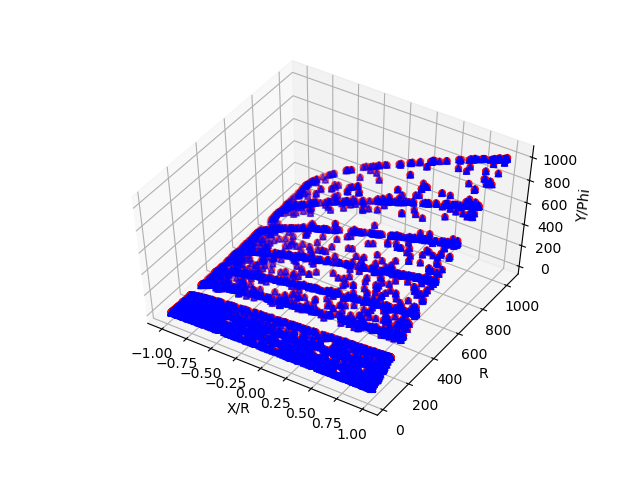

In [16]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:5000,'x_r']
    ys = r1000tru_p_sort.loc[1:5000,'r']
    zs = r1000tru_p_sort.loc[1:5000,'ty']/r1000tru_p_sort.loc[1:5000,'phi']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X/R')
ax.set_ylabel('R')
ax.set_zlabel('Y/Phi')

plt.show()

<IPython.core.display.Javascript object>


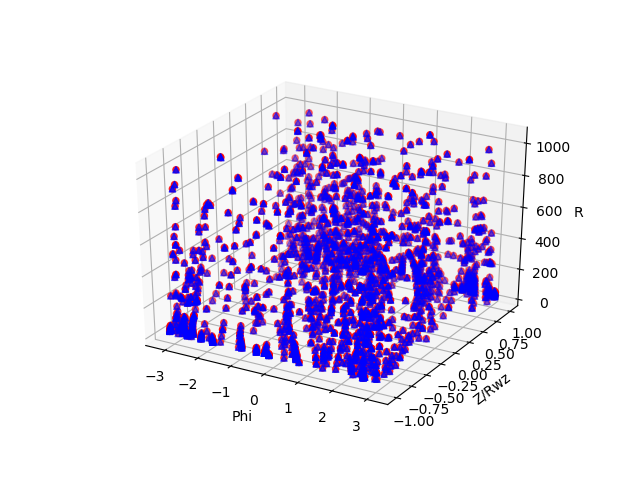

In [95]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:2000,'phi']
    ys = r1000tru_p_sort.loc[1:2000,'z_rwz']
    zs = r1000tru_p_sort.loc[1:2000,'r']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Phi')
ax.set_ylabel('Z/Rwz')
ax.set_zlabel('R')

plt.show()

<IPython.core.display.Javascript object>


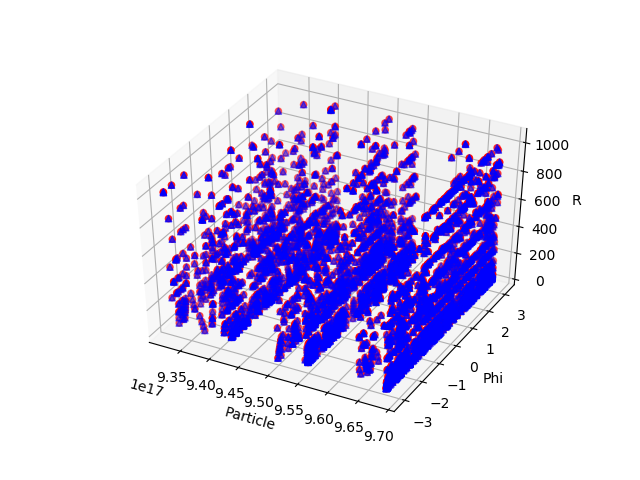

In [69]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:5000,'particle_id']
    ys = r1000tru_p_sort.loc[1:5000,'phi']
    zs = r1000tru_p_sort.loc[1:5000,'r']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Particle')
ax.set_ylabel('Phi')
ax.set_zlabel('R')

plt.show()

<IPython.core.display.Javascript object>


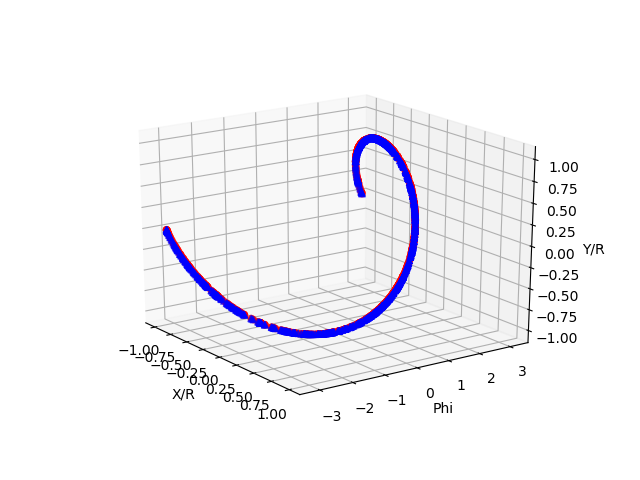

In [5]:
# Run in Python
# adapted from https://stackoverflow.com/questions/
#   33436221/displaying-rotatable-3d-plots-in-ipython-or-ipython-notebook/33440743#33440743
# 
# Checking conformal approaches

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# pd.set_option('html',False)
pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

# Note that y and z axes are flipped for better viewing across Z axis
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
for c, m, zl, zh in [('r', 'o', -60, -25), ('b', '^', -30, -5)]:
    xs = r1000tru_p_sort.loc[1:1000,'x_r']
    ys = r1000tru_p_sort.loc[1:1000,'phi']
    zs = r1000tru_p_sort.loc[1:1000,'y_r']
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X/R')
ax.set_ylabel('Phi')
ax.set_zlabel('Y/R')

plt.show()

In [3]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform


def cartesian_to_cylindrical(x, y, z):
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    
    return r, phi, z


def create_hough_matrix(hits):
    
    hough_matrix = hits[['hit_id', 'x', 'y', 'z']].copy()
    hough_matrix.columns = ['HitID', 'X', 'Y', 'Z']
    
    r, phi, z = cartesian_to_cylindrical(hough_matrix['X'].values, 
                                         hough_matrix['Y'].values, 
                                         hough_matrix['Z'].values)

    hough_matrix['R'] = r
    hough_matrix['Phi'] = phi
    
    return hough_matrix


def add_theta(hough_matrix, theta):
    hough_matrix['Theta'] = theta
    return hough_matrix

def add_r0_inv(hough_matrix):
    hough_matrix['R0Inv'] = (2. * np.cos(hough_matrix['Phi'] - hough_matrix['Theta']) / hough_matrix['R']).values
    return hough_matrix

def add_gamma(hough_matrix):
    hough_matrix['Gamma'] = hough_matrix['Z']/hough_matrix['R']
    return hough_matrix


def digitize_column(hough_matrix, col, N, min_val=None, max_val=None):
    
    x = hough_matrix[col].values
    if min_val is not None and max_val is not None:
        bins = np.linspace(min_val, max_val, N)
    else:
        bins = np.linspace(x.min(), x.max(), N)
    bin_ids = np.digitize(x, bins)
    hough_matrix[col+'Digi'] = bin_ids
    
    return hough_matrix


def combine_digi(hough_matrix, columns):
    
    hough_matrix['ComboDigi'] = np.zeros(len(hough_matrix))
    
    for i_col, acol in enumerate(columns):
        digi = hough_matrix[acol]
        hough_matrix['ComboDigi'] += digi * 10**(i_col * 5)
    
    return hough_matrix


def count_combo_digi(hough_matrix):
    
    unique, indeces, counts = np.unique(hough_matrix['ComboDigi'].values, 
                                     return_counts=True, return_inverse=True)
    hough_matrix['ComboDigiCounts'] = counts[indeces]
    
    return hough_matrix

def out_of_border_counters_to_zero(hough_matrix, col, N):
    hough_matrix['ComboDigiCounts'] *= (hough_matrix[col].values != 0) * (hough_matrix[col].values != N)
    return hough_matrix

def one_slice(hough_matrix, theta, N_bins_r0inv, N_bins_gamma, min_hits):
        
    tracks = []
    
    hough_matrix = add_theta(hough_matrix, theta)
    hough_matrix = add_r0_inv(hough_matrix)
    hough_matrix = add_gamma(hough_matrix)

    hough_matrix = digitize_column(hough_matrix, 'R0Inv', N_bins_r0inv, -0.02, 0.02) # Tune it.
    hough_matrix = digitize_column(hough_matrix, 'Gamma', N_bins_gamma, -50, 50) # Tune it.

    hough_matrix = combine_digi(hough_matrix, ['R0InvDigi', 'GammaDigi'])
    hough_matrix = count_combo_digi(hough_matrix)

    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'R0InvDigi', N_bins_r0inv)
    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'GammaDigi', N_bins_gamma)
    
    counts = hough_matrix.ComboDigiCounts.values
    bins = hough_matrix.ComboDigi.values
    hit_ids = np.arange(len(hough_matrix))
    for abin in np.unique(bins[counts >= min_hits]):
        atrack = hit_ids[(bins == abin)]
        tracks.append(atrack)
        
    return tracks, hough_matrix




class Clusterer(object):
    
    def __init__(self, N_bins_r0inv, N_bins_gamma, N_theta, min_hits):
        
        self.N_bins_r0inv = N_bins_r0inv 
        self.N_bins_gamma = N_bins_gamma
        self.N_theta = N_theta
        self.min_hits = min_hits
    
    def predict(self, hits):
        
        tracks = []

        hough_matrix = create_hough_matrix(hits)
        for theta in np.linspace(-np.pi, np.pi, self.N_theta):
            slice_tracks, hough_matrix = one_slice(hough_matrix, theta, self.N_bins_r0inv, self.N_bins_gamma, self.min_hits)
            tracks += list(slice_tracks)

        labels = np.zeros(len(hits))
        used = np.zeros(len(hits))
        track_id = 0
        for atrack in tracks:
            u_track = atrack[used[atrack] == 0]
            if len(u_track) >= self.min_hits:
                labels[u_track] = track_id
                used[u_track] = 1
                track_id += 1
            
        return labels

In [61]:
# Run in Python
# from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [29]:
# Run in Python
#
# EDITED from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#   TO USE SPHERICAL TRANSFORM

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
# added:
        hits['z2'] = z/r

#removed:
#        r = np.sqrt(x**2 + y**2)
#        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [11]:
# Run in Python
#
# EDITED from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#   TO USE X/Rxyz by Y by Z/Rxyz transform

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r_xyz = np.sqrt(x**2 + y**2 + z**2)        
        
        hits['x2'] = x/r_xyz
        hits['y2'] = y
        hits['z2'] = z/r_xyz

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [11]:
# Run in Python
#
# EDITED from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#   TO USE X/Rxy^2 by Y/Rxy^2 by Z/Rxyz transform

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r_xy =  np.sqrt(x**2 + y**2)
        r_xyz = np.sqrt(x**2 + y**2 + z**2)        
        
        hits['x2'] = x/(r_xy**2)
        hits['y2'] = y/(r_xy**2)
        hits['z2'] = z/r_xyz

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [85]:
# Run in Python
#
# EDITED from DBSCAN benchmark: https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#   TO USE R by Phi by Z/Rxyz transform

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r_xy =  np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        r_xyz = np.sqrt(x**2 + y**2 + z**2)        
        
#       hits['x2'] = x/r_xy
#       hits['y2'] = y/phi
#       hits['z2'] = z/r_xyz
        hits['r_xy'] = r_xy
        hits['phi'] = phi
        hits['z2'] = z/r_xyz

        ss = StandardScaler()
        X = ss.fit_transform(hits[['r_xy', 'phi', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [84]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform
#
#     Edited for manual pipelining of test events, 25 at a time. 
#        Need to load sets manually into library.
#

"""
Create a submission

Recognize tracks in all (or subset of) events of the test dataset and create a submission file.

Warning: it takes about 100s per one event.

edited from 
"""

path_to_test = "test/"
test_dataset_submissions = []

create_submission = True # True for submission 

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells'], skip=0, nevents=25):

        # Track pattern recognition
        model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create portion of submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('submission_100_124.csv', index=False)

Event ID:  100
Event ID:  101
Event ID:  102
Event ID:  103
Event ID:  104
Event ID:  105
Event ID:  106
Event ID:  107
Event ID:  108
Event ID:  109
Event ID:  110
Event ID:  111
Event ID:  112
Event ID:  113
Event ID:  114
Event ID:  115
Event ID:  116
Event ID:  117
Event ID:  118
Event ID:  119
Event ID:  120
Event ID:  121
Event ID:  122
Event ID:  123
Event ID:  124


In [29]:
# Run in Python
# for HOUGH
# Combining portions of submission file

submit_00_24=pd.read_csv('submission_00_24.csv')
# 2755379 rows 
submit_25_49=pd.read_csv('submission_25_49.csv')
# 2672513 rows
submit_50_74=pd.read_csv('submission_50_74.csv')
# 2783134 rows
submit_75_99=pd.read_csv('submission_75_99.csv')
# 2760795 rows
submit_100_124=pd.read_csv('submission_100_124.csv')
# 2769645 rows

submit_0_124=pd.concat([submit_00_24, submit_25_49, submit_50_74, submit_75_99, submit_100_124],axis=0)

In [9]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import os

#from trackml.dataset import load_event, load_dataset
#from trackml.score import score_event

In [48]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform
# Warning: it takes about 100s per one event.

%%time
model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
labels = model.predict(hits)

CPU times: user 2min 50s, sys: 1.1 s, total: 2min 51s
Wall time: 2min 51s


In [50]:
# Run in Python
# for DBSCAN

# model = Clusterer(eps=0.008)
model = Clusterer(eps=0.004)
labels = model.predict(hits)

In [51]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform

submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [52]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform

print("Your score: ", score)

Your score:  0.12543200698200963


In [57]:
np.savetxt('labels1.csv', labels, delimiter=",")

In [49]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform

"""
Score

Compute the score for this event. The dummy submission output of create_one_event_submission 
is created only to be the second parameter of the score_event function. It should not be 
confused with a well-behaved submission for the test set.
"""

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [ ]:
# Run in Python
# from Hough transform: https://www.kaggle.com/mikhailhushchyn/hough-transform

"""
Recognize tracks in all training events of a dataset

In this example, the dataset is the whole training set. 
This is a simple loop over the one-event actions: because of there is no actual training. 
This may take a very long time. To run on only a subset, use e.g.

 load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

Warning: it takes about 100s per one event.
"""

dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=1000, nevents=5):
        
    # Track pattern recognition
    model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

In [ ]:
# old R code below

In [38]:
# the first ten training events (1000-1009) are downloaded (hits and truth files)
# the first ten test events (0-9) are downloaded (hits and cells files)
list.files()

AttributeError: type object 'list' has no attribute 'files'

In [2]:
# naming convention: r=tRaining set or s=teSt set, then event number, then hit=hits file or tru=truth file
r1000hit <- read.csv('event000001000-hits.csv')

In [3]:
str(r1000hit)

'data.frame':	120939 obs. of  7 variables:
 $ hit_id   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ x        : num  -64.4 -55.3 -83.8 -96.1 -62.7 ...
 $ y        : num  -7.164 0.635 -1.143 -8.241 -9.371 ...
 $ z        : num  -1502 -1502 -1502 -1502 -1502 ...
 $ volume_id: int  7 7 7 7 7 7 7 7 7 7 ...
 $ layer_id : int  2 2 2 2 2 2 2 2 2 2 ...
 $ module_id: int  1 1 1 1 1 1 1 1 1 1 ...


In [4]:
svg('test_plot11.svg')
plot(r1000hit[1:100,2], r1000hit[1:100,3])
dev.off()

png 
  2

<img src='test_plot11.svg'>

In [5]:
# TO DO: need greater precision on numeric
r1000tru <- read.csv('event000001000-truth.csv', colClasses = c("integer", "character", "numeric", "numeric", "numeric", 
                                                               "numeric", "numeric", "numeric", "numeric"))
r1000tru <- r1000tru[order(r1000tru$particle_id, decreasing=TRUE),]
write.csv(r1000tru, file="r1000tru.csv")

In [6]:
str(r1000tru)

'data.frame':	120939 obs. of  9 variables:
 $ hit_id     : int  1382 19963 27856 34761 41048 41055 69598 69621 69683 72692 ...
 $ particle_id: chr  "99085239116103680" "99083933446045696" "99083933446045696" "99083933446045696" ...
 $ tx         : num  -109.65 17.42 22.18 19.69 6.72 ...
 $ ty         : num  38 -27.3 -68 -114.8 -170.8 ...
 $ tz         : num  -1502 -49.2 -104.6 -166.2 -240.2 ...
 $ tpx        : num  -0.93577 0.03316 0.00669 -0.02273 -0.05486 ...
 $ tpy        : num  0.262 -0.166 -0.169 -0.17 -0.164 ...
 $ tpz        : num  -11.68 -0.228 -0.228 -0.225 -0.222 ...
 $ weight     : num  0.00 1.16e-05 1.01e-05 8.52e-06 6.97e-06 ...


In [7]:
#the img src markdown below will use outdated figure, so need to remove old figure and rename to new figure
#file.remove('test_plot3.svg')
svg('test_plot12.svg')
coplot(r1000tru[1:200,3] ~ r1000tru[1:200,4] | r1000tru[1:200,2], show.given=FALSE)
dev.off()

png 
  2

<img src='test_plot12.svg'>

In [8]:
install.packages("scatterplot3d")
library(scatterplot3d)
# args(scatterplot3d)

Installing package into ‘/home/nbuser/R’
(as ‘lib’ is unspecified)


In [9]:
svg('test_plot13.svg')
scatterplot3d(r1000tru[1:200,3], r1000tru[1:200,5], r1000tru[1:200,4])
dev.off()

png 
  2

<img src='test_plot13.svg'>

In [10]:
svg('test_plot14.svg')
scatterplot3d(r1000tru[1:200,3], r1000tru[1:200,5], r1000tru[1:200,4], type='l')
dev.off()

png 
  2

<img src='test_plot14.svg'>